In [2]:
 !pip install smogn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 29.0 MB/s 


In [4]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 28.0 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 209 kB 53.8 MB/s 
     |████████████████████████████████| 78 kB 5.1 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 146 kB 60.1 MB/s 
     |████████████████████████████████| 112 kB 53.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=07044fbf5941013caf21f8bc73d2d36e9720e56b8419ce66ac67799e590eff32
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import radians, cos, sin, asin, sqrt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor as KNN
import xgboost as xgb
import smogn

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,Activation
from tensorflow.keras.models import Sequential
import optuna
import keras_tuner as kt

In [6]:
#TODO: IF YOUR DIRECTORY IS DIFFERENT, PLEASE PROVIDE THE CORRECT PATH
df = pd.read_csv('DATA-ALL-labor-rates-V2.csv')

In [7]:
df.describe()

CompanyPostalCode     CategoryId   LaborRate     MeanIncome  \
count        3773.000000    3773.000000  3773.00000    3773.000000   
mean        93540.916777  108285.499602    58.73920  134876.103631   
std          1840.118775   23456.643056    22.91896   59270.984478   
min         90006.000000   70209.000000    18.00000   53427.000000   
25%         92081.000000   89740.000000    35.00000   98413.000000   
50%         94121.000000  103949.000000    50.00000  116324.000000   
75%         95240.000000  127273.000000    75.00000  149569.000000   
max         95973.000000  151979.000000   185.00000  264264.000000   

          HousePrice  BCI_County_TimeSeries  
count    3773.000000            3773.000000  
mean   134876.103631            7121.686456  
std     59270.984478             527.380445  
min     53427.000000            6388.000000  
25%     98413.000000            6698.000000  
50%    116324.000000            6958.000000  
75%    149569.000000            7398.000000  
max    264264.000000            9280.000000

In [8]:
df.corr()

CompanyPostalCode  CategoryId  LaborRate  MeanIncome  \
CompanyPostalCode               1.000000    0.151291   0.361471    0.333002   
CategoryId                      0.151291    1.000000   0.214463    0.123430   
LaborRate                       0.361471    0.214463   1.000000    0.317233   
MeanIncome                      0.333002    0.123430   0.317233    1.000000   
HousePrice                      0.333002    0.123430   0.317233    1.000000   
BCI_County_TimeSeries           0.254966    0.769060   0.371191    0.509641   

                       HousePrice  BCI_County_TimeSeries  
CompanyPostalCode        0.333002               0.254966  
CategoryId               0.123430               0.769060  
LaborRate                0.317233               0.371191  
MeanIncome               1.000000               0.509641  
HousePrice               1.000000               0.509641  
BCI_County_TimeSeries    0.509641               1.000000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


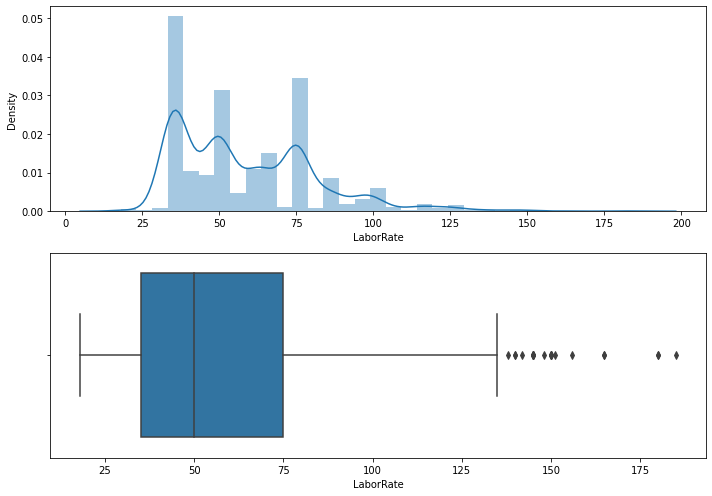

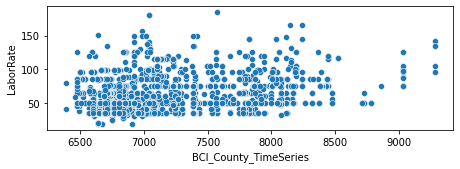

In [9]:
#visualizing house prices
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(df['LaborRate'])
fig.add_subplot(2,1,2)
sns.boxplot(df['LaborRate'])
plt.tight_layout()

#visualizing square footage of (home,lot,above and basement)
fig = plt.figure(figsize=(16,5))
fig.add_subplot(2,2,1)
sns.scatterplot(df['BCI_County_TimeSeries'], df['LaborRate'])

In [10]:
#break date into month and year
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].apply(lambda date:date.month)
df['Year'] = df['Date'].apply(lambda date:date.year)

In [11]:
df.corr()

CompanyPostalCode  CategoryId  LaborRate  MeanIncome  \
CompanyPostalCode               1.000000    0.151291   0.361471    0.333002   
CategoryId                      0.151291    1.000000   0.214463    0.123430   
LaborRate                       0.361471    0.214463   1.000000    0.317233   
MeanIncome                      0.333002    0.123430   0.317233    1.000000   
HousePrice                      0.333002    0.123430   0.317233    1.000000   
BCI_County_TimeSeries           0.254966    0.769060   0.371191    0.509641   
Month                          -0.073057    0.208313  -0.009485   -0.090812   
Year                            0.182170    0.930318   0.219148    0.157374   

                       HousePrice  BCI_County_TimeSeries     Month      Year  
CompanyPostalCode        0.333002               0.254966 -0.073057  0.182170  
CategoryId               0.123430               0.769060  0.208313  0.930318  
LaborRate                0.317233               0.371191 -0.009485  0.219148  
MeanIncome               1.000000               0.509641 -0.090812  0.157374  
HousePrice               1.000000               0.509641 -0.090812  0.157374  
BCI_County_TimeSeries    0.509641               1.000000  0.141351  0.694915  
Month                   -0.090812               0.141351  1.000000 -0.137727  
Year                     0.157374               0.694915 -0.137727  1.000000

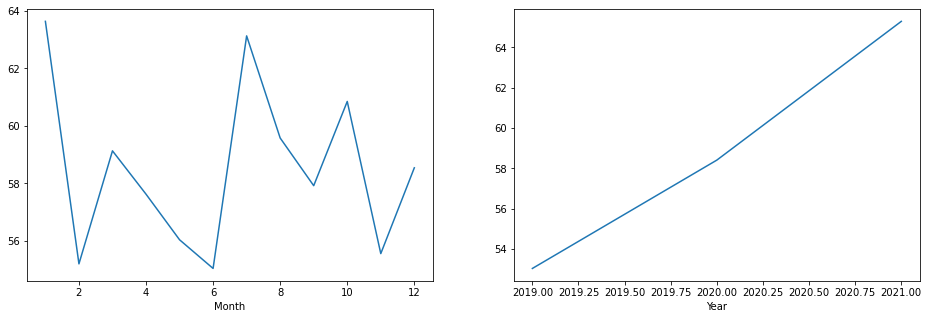

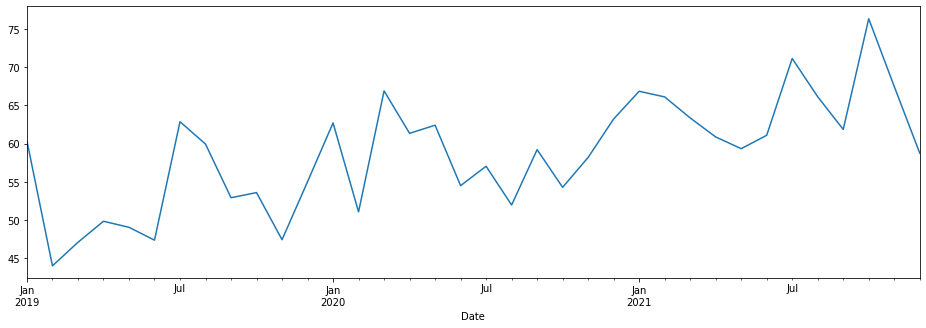

In [12]:
#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
df.groupby('Month').mean()['LaborRate'].plot()
fig.add_subplot(1,2,2)
df.groupby('Year').mean()['LaborRate'].plot()
fig = plt.figure(figsize=(16,5))
df.groupby('Date').mean()['LaborRate'].plot()

# **Neural Network Labor Prediction**

In [13]:
X = df[['Year','Month','BCI_County_TimeSeries','MeanIncome']].values
y = df['LaborRate'].values

In [14]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [15]:
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(float))
X_test = s_scaler.transform(X_test.astype(float))

In [16]:
def print_reports(X_train, X_test, y_train, y_test,y_pred):  
  print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
  print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
  print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
  print('R2:', metrics.r2_score(y_test, y_pred))

# Model 2: Keras Regressions

In [17]:
BATCH_SIZE=64

def create_model(hp):
    model = keras.Sequential()
    
    for i in range(hp.Choice('hidden_layers', values=[1])):
        model.add(keras.layers.Dense(units = hp.Int("units_{}".format(i+1),min_value=2,max_value=1024,step=1), activation='relu')),
        model.add(keras.layers.Dropout(hp.Choice("dropout_{}".format(i+1), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))),
        model.add(keras.layers.Dense(units = hp.Int("units_{}".format(i+1),min_value=2,max_value=1024,step=1), activation='relu')),
        model.add(keras.layers.Dropout(hp.Choice("dropout_{}".format(i+1), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))),
        model.add(keras.layers.Dense(units = hp.Int("units_{}".format(i+1),min_value=2,max_value=1024,step=1), activation='relu')),
        model.add(keras.layers.Dropout(hp.Choice("dropout_{}".format(i+1), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))),
        model.add(keras.layers.Dense(units = hp.Int("units_{}".format(i+1),min_value=2,max_value=1024,step=1), activation='relu')),
        model.add(keras.layers.Dropout(hp.Choice("dropout_{}".format(i+1), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))),
    model.add(keras.layers.Dense(1, activation='sigmoid')),
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]) ),
                  metrics=[[keras.metrics.MeanSquaredError()]])
    
    return model

In [18]:
tuner_hb = kt.Hyperband(
        create_model,
        objective="val_mean_squared_error",
        factor=3,
        max_epochs=50,
        hyperband_iterations=1,
        directory='my_dir',
        project_name='kt',
        overwrite=True)

In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=5, restore_best_weights=True)

In [20]:
tuner_hb.search(X_train, y_train,validation_data=(X_test, y_test), callbacks=[early_stop])

Trial 90 Complete [00h 00m 04s]
val_mean_squared_error: 3923.7119140625

Best val_mean_squared_error So Far: 3923.7119140625
Total elapsed time: 00h 12m 06s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner_hb.results_summary(num_trials=1)

Results summary
Results in my_dir/kt
Showing 1 best trials
Trial summary
Hyperparameters:
hidden_layers: 1
units_1: 686
dropout_1: 0.2
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 3923.7119140625


In [22]:
best_hps_hb=tuner_hb.get_best_hyperparameters()[0]

In [23]:
hypermodel_hb = tuner_hb.hypermodel.build(best_hps_hb)

In [24]:
history = hypermodel_hb.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/400
79/79 [==============================] - 3s 24ms/step - loss: 3827.7451 - mean_squared_error: 3827.7451 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119
Epoch 2/400
79/79 [==============================] - 2s 21ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119
Epoch 3/400
79/79 [==============================] - 2s 21ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119
Epoch 4/400
79/79 [==============================] - 2s 20ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119
Epoch 5/400
79/79 [==============================] - 2s 21ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119
Epoch 6/400
79/79 [==============================] - 2s 21ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 39

In [25]:
hypermodel_hb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 686)               3430      
                                                                 
 dropout_4 (Dropout)         (None, 686)               0         
                                                                 
 dense_6 (Dense)             (None, 686)               471282    
                                                                 
 dropout_5 (Dropout)         (None, 686)               0         
                                                                 
 dense_7 (Dense)             (None, 686)               471282    
                                                                 
 dropout_6 (Dropout)         (None, 686)               0         
                                                                 
 dense_8 (Dense)             (None, 686)              

In [26]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [27]:
# retrain the model
hypermodel_hb.fit(X_train, y_train, epochs=best_epoch, batch_size=BATCH_SIZE,validation_data=(X_test, y_test), callbacks=[early_stop])

40/40 [==============================] - 1s 27ms/step - loss: 3827.0244 - mean_squared_error: 3827.0244 - val_loss: 3923.7119 - val_mean_squared_error: 3923.7119


In [28]:
y_pred_prob_hb = hypermodel_hb.predict(X_test)
y_pred_hb = y_pred_prob_hb.round()

In [29]:
print_reports(X_train, X_test, y_train, y_test,y_pred_hb)

MAE: 58.201444622792934
MSE: 3923.7118780096307
RMSE: 62.63953925444879
VarScore: 0.0
R2: -6.316212284755185


In [30]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


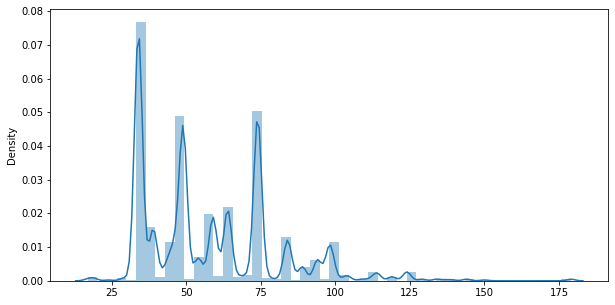

In [31]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred_hb)
sns.distplot(residuals)

In [ ]:
tuner_rs = kt.RandomSearch(
        create_model,
        objective="val_mean_squared_error",
        max_trials=150,
        directory='my_dir',
        project_name='kt',
        overwrite=True)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=5, restore_best_weights=True)

In [ ]:
tuner_rs.search(X_train, y_train,validation_data=(X_test, y_test))

Trial 117 Complete [00h 00m 01s]
val_mean_squared_error: 8445.4814453125

Best val_mean_squared_error So Far: 8445.4814453125
Total elapsed time: 00h 06m 05s

Search: Running Trial #118

Value             |Best Value So Far |Hyperparameter
1                 |1                 |hidden_layers
878               |946               |units_1
0.01              |0.001             |learning_rate

73/73 [==============================] - 3s 38ms/step - loss: 8221.6533 - mean_squared_error: 8221.6533 - val_loss: 8445.4814 - val_mean_squared_error: 8445.4814


In [ ]:
tuner_rs.results_summary(num_trials=1)

In [ ]:
best_hps_rs=tuner_rs.get_best_hyperparameters()[0]

In [ ]:
hypermodel_rs = tuner_rs.hypermodel.build(best_hps_rs)

In [ ]:
history = hypermodel_rs.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

In [ ]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(max(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel_rs = tuner_rs.hypermodel.build(best_hps_rs)
history = hypermodel_rs.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_val, y_val), callbacks=[early_stop])

In [ ]:
print_reports(X_train, X_test, y_train, y_test,y_pred)

In [ ]:
model = Sequential()
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mse")
model.fit(x = X_train, y = y_train,
          validation_data = (X_test,y_test),
          batch_size=128, epochs=400, verbose = 0)
model.summary()

y_pred = model.predict(X_test)

# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

In [ ]:
print_reports(X_train, X_test, y_train, y_test,y_pred)

Score: 0.2779609590633514
MAE: 17.13889542161843
MSE: 548.8068333288649
RMSE: 23.42662658875291
VarScore: 0.535968943438876
R2: 0.5354088327196065


# Model 3: XGBoost

[21:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Score: 0.7200100221232258
MAE: 12.76306535153142
MSE: 328.8904185906636
RMSE: 18.135336186314927
VarScore: 0.720202454125297
R2: 0.7200100221232258


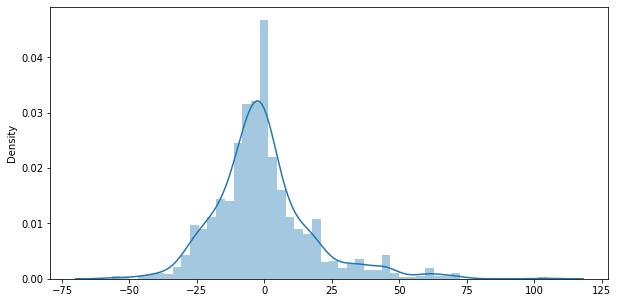

In [ ]:
# Multiple Liner Regression
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)

#predicting the test set result
y_pred = regressor.predict(X_test)

# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

print_reports(X_train, X_test, y_train, y_test,y_pred)

# Model 4: Random Forest Regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Score: 0.8074038051227899
MAE: 8.549744602240203
MSE: 226.2332517487909
RMSE: 15.041052215479837
VarScore: 0.8074287762138583
R2: 0.8074038051227899


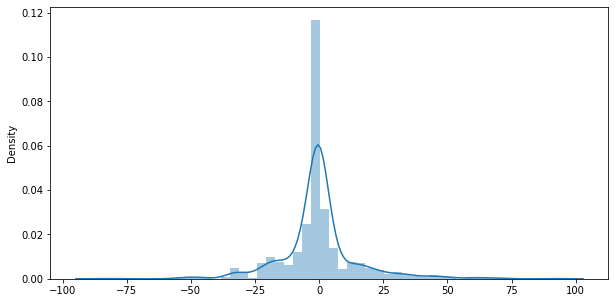

In [ ]:
# Multiple Liner Regression
regressor = RandomForestRegressor()  
regressor.fit(X_train, y_train)

#predicting the test set result
y_pred = regressor.predict(X_test)

# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

print_reports(X_train, X_test, y_train, y_test,y_pred)

# Model 5: KNN

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Score: 0.6341093696289706
MAE: 9.560140474100088
MSE: 429.79367866549603
RMSE: 20.731465907298887
VarScore: 0.6368590328320434
R2: 0.6341093696289706


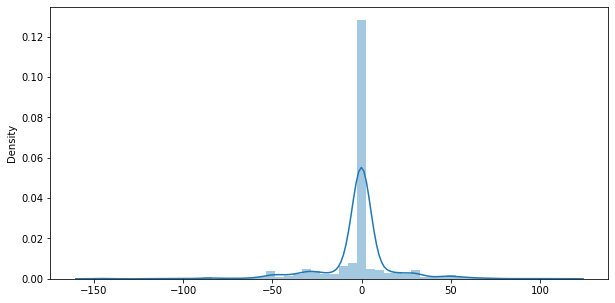

In [ ]:
# Multiple Liner Regression
regressor = KNN(n_neighbors=1)
regressor.fit(X_train, y_train)

#predicting the test set result
y_pred = regressor.predict(X_test)

# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)

print_reports(X_train, X_test, y_train, y_test,y_pred)

In [ ]:
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mse")
model.fit(x = X_train, y = y_train,
          validation_data = (X_test,y_test),
          batch_size=128, epochs=400, verbose = 0)
model.summary()

y_pred = model.predict(X_test)

# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test - y_pred)
sns.distplot(residuals)


print_reports(X_train, X_test, y_train, y_test,y_pred)